In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import classy
from scipy.interpolate import interp1d

In [2]:
DESI = np.load("../data/products/DESI.npz")
DESI10n = np.load("../data/products/DESI_10n.npz")
DESIfs = np.load("../data/products/DESI_fs.npz")

In [3]:
DESI_H_threshold = min(DESI["H_err"]/DESI["H_data"])
DESI_dA_threshold = min(DESI["dA_err"]/DESI["dA_data"])
DESI_fs8_threshold = min(DESI["fs8_err"]/DESI["fs8_data"])

In [4]:
DESI10n_H_threshold = min(DESI10n["H_err"]/DESI10n["H_data"])
DESI10n_dA_threshold = min(DESI10n["dA_err"]/DESI10n["dA_data"])
DESI10n_fs8_threshold = min(DESI10n["fs8_err"]/DESI10n["fs8_data"])

In [5]:
DESIfs_H_threshold = min(DESIfs["H_err"]/DESIfs["H_data"])
DESIfs_dA_threshold = min(DESIfs["dA_err"]/DESIfs["dA_data"])
DESIfs_fs8_threshold = min(DESIfs["fs8_err"]/DESIfs["fs8_data"])

# 1. Exact calculation
First, we compute distances and growth exactly

In [6]:
zmax = 1085.
pars = {'Omega_c': 0.26, 'Omega_b': 0.05, 'h': 0.67, 'n_s': 0.9665, 'sigma8': 0.805761}
params = {'Omega_cdm': 0.26, 'Omega_b': 0.05, 'h': 0.67, 'n_s': 0.9665, 'sigma8': 0.805761}
class_cosmo = classy.Class()
class_cosmo.set({ 'output':'mPk', 'P_k_max_h/Mpc': 20, 'z_max_pk': 1085})
class_cosmo.set(params)
class_cosmo.compute()
cosmo = ccl.Cosmology(**pars)
zfine = np.linspace(0, zmax, 1000000)
afine = 1./(1+zfine)
xfine = np.log(1+zfine)

chi_i = ccl.comoving_angular_distance(cosmo, afine)

class_dd_i = np.array([class_cosmo.scale_independent_growth_factor(z) for z in zfine])
dd_i = ccl.growth_factor(cosmo, afine)

class_ddp_i = np.array([class_cosmo.scale_independent_growth_factor_f(z) for z in zfine])*class_dd_i
ddp_i = ccl.growth_rate(cosmo, afine)*dd_i

class_ddp_i *= class_cosmo.sigma8()/class_dd_i[0]
class_dd_i *= class_cosmo.sigma8()/class_dd_i[0]
ddp_i *= cosmo['sigma8']/dd_i[0]
dd_i *= cosmo['sigma8']/dd_i[0]

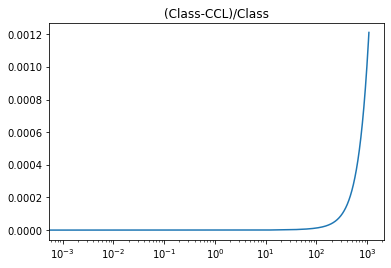

In [7]:
plt.plot(zfine, (class_dd_i-dd_i)/class_dd_i)
plt.xscale('log')
plt.title('(Class-CCL)/Class');

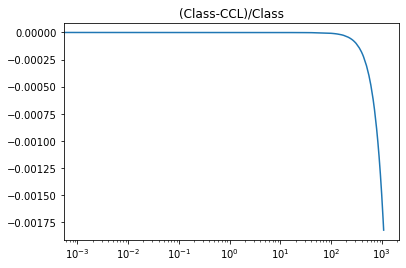

In [8]:
plt.plot(zfine, (class_ddp_i-ddp_i)/class_ddp_i)
plt.xscale('log')
plt.title('(Class-CCL)/Class');

# 2. Distances
Now we compute distances using $x=\log(1+z)$ as an integration variable. We will use linear interpolation to evaluate the result on the fine grid of redshifts defined above.

$$
\chi(z) = \int_0^z d\log(1+z)\, \frac{c(1+z)}{H(z)}
$$

In [9]:
def make_idx(z_gp, z_int):
    idxs = np.array([])
    for z in z_int:
        closest_z = min(z_gp, key=lambda x:abs(x-z))
        idx = np.array([int(i) for i in range(len(z_gp)) if z_gp[i]==closest_z])
        if closest_z >= z:
            idx += -1
        idxs = np.append(idxs, idx)
    return np.array(idxs).astype(int)

def make_U(z_gp, z_int, idxs):
    dz = np.diff(z_gp)[idxs]
    return (z_int-z_gp[idxs])/dz

In [10]:
x_int = np.linspace(0, np.log(1+zmax), 200)
dx = np.mean(np.diff(x_int))
z_int = np.exp(x_int)-1
a_int = 1./(1+z_int)

x_gp = np.linspace(0, np.log(1+zmax), 150)
z_gp = np.exp(x_gp)-1
a_gp = 1./(1+z_gp)
# H(z) (in Jaime's case this would be the GP)
hz_pure = ccl.h_over_h0(cosmo, a_gp)*cosmo['h']/ccl.physical_constants.CLIGHT_HMPC
hz_true = ccl.h_over_h0(cosmo, a_int)*cosmo['h']/ccl.physical_constants.CLIGHT_HMPC
idx = make_idx(z_gp, z_int)
U = make_U(z_gp, z_int, idx)


hz = np.zeros(200)
hz[1:] = hz_pure[idx[1:]]+(hz_pure[idx[1:]+1]-hz_pure[idx[1:]])*U[1:]
hz[0] = hz_pure[0]

/tmp/ipykernel_1001/4213088053.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


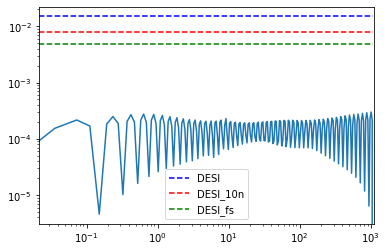

In [11]:
plt.plot(z_int, (hz-hz_true)/hz_true)
plt.plot(z_int, DESI_H_threshold*np.ones_like(z_int), 'b--', label="DESI")
plt.plot(z_int, DESI10n_H_threshold*np.ones_like(z_int), 'r--', label="DESI_10n")
plt.plot(z_int, DESIfs_H_threshold*np.ones_like(z_int), 'g--', label="DESI_fs")
plt.xscale("log")
plt.yscale("log")
plt.xlim(0, 1100)
plt.legend()

In [12]:
def my_cumsum(a, order=0):
    ''' Cumulative sum enforcing zero integral in the first element.
    If order!=0 trapezoidal integration will be used.'''
    r = np.zeros(len(a)+1)
    r[1:] = np.cumsum(a)
    if order == 0:  # Rectangular integration
        return r[:-1]
    else:  # Trapezoidal integration
        return 0.5*(r[1:]+r[:-1])-0.5*r[1]
    return r

def get_chi(z, hz, dx, order=0):
    ''' Computes the radial comoving distance numerically from
    an array of H(z).'''
    return dx*my_cumsum((1+z)/hz, order=order)

def compute_chi(nz, zout):
    # Equi-spaced log(1+z)
    nz_int = 500
    x_int = np.linspace(0, np.log(1+zmax), nz_int)
    dx = np.mean(np.diff(x_int))
    z_int = np.exp(x_int)-1
    a_int = 1./(1+z_int)

    x_gp = np.linspace(0, np.log(1+zmax), nz)
    z_gp = np.exp(x_gp)-1
    a_gp = 1./(1+z_gp)
    # H(z) (in Jaime's case this would be the GP)
    hz_pure = ccl.h_over_h0(cosmo, a_gp)*cosmo['h']/ccl.physical_constants.CLIGHT_HMPC
    hz_true = ccl.h_over_h0(cosmo, a_int)*cosmo['h']/ccl.physical_constants.CLIGHT_HMPC
    idx = make_idx(z_gp, z_int)
    U = make_U(z_gp, z_int, idx)

    hz = np.zeros(nz_int)
    hz[1:] = hz_pure[idx[1:]]+(hz_pure[idx[1:]+1]-hz_pure[idx[1:]])*U[1:]
    hz[0] = hz_pure[0]
    
    # 0th order integral
    chiz_0 = get_chi(z_int, hz, dx, order=0)
    # 1st order integral
    chiz_1 = get_chi(z_int, hz, dx, order=1)

    # Interpolate onto a fine grid
    chiz_0i = interp1d(x_int, chiz_0, kind='linear', fill_value=0, bounds_error=False)
    chiz_1i = interp1d(x_int, chiz_1, kind='linear', fill_value=0, bounds_error=False)
    return zout, chiz_0i(np.log(1+zout)), chiz_1i(np.log(1+zout))

/tmp/ipykernel_1001/353246105.py:22: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


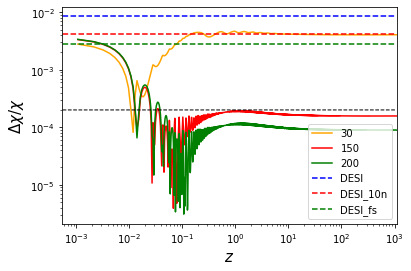

In [13]:
# Compute and compare with exact calculation
zz, chi0_10, chi1_10 = compute_chi(30, zfine)
zz, chi0_100, chi1_100 = compute_chi(150, zfine)
zz, chi0_200, chi1_200 = compute_chi(200, zfine)
#zz, chi0_300, chi1_300 = compute_chi(300, zfine)
#zz, chi0_500, chi1_500 = compute_chi(500, zfine)
#plt.plot(zz[1:], np.fabs(chi0_10[1:]/chi_i[1:]-1), '--', color='orange')
plt.plot(zz[1:], np.fabs(chi1_10[1:]/chi_i[1:]-1), '-', color='orange', label='30')
#plt.plot(zz[1:], np.fabs(chi0_100[1:]/chi_i[1:]-1), 'r--')
plt.plot(zz[1:], np.fabs(chi1_100[1:]/chi_i[1:]-1), 'r-', label='150')
#plt.plot(zz[1:], np.fabs(chi0_200[1:]/chi_i[1:]-1), 'g--')
plt.plot(zz[1:], np.fabs(chi1_200[1:]/chi_i[1:]-1), 'g-', label='200')
#plt.plot(zz[1:], np.fabs(chi0_300[1:]/chi_i[1:]-1), 'b--')
#plt.plot(zz[1:], np.fabs(chi1_300[1:]/chi_i[1:]-1), 'b-', label='300')
#plt.plot(zz[1:], np.fabs(chi0_500[1:]/chi_i[1:]-1), 'y--')
#plt.plot(zz[1:], np.fabs(chi1_500[1:]/chi_i[1:]-1), 'y-', label='500')
plt.plot(zz, np.ones_like(zz)*0.0002, 'k--', lw=1)
plt.plot(z_int, DESI_dA_threshold*np.ones_like(z_int), 'b--', label="DESI")
plt.plot(z_int, DESI10n_dA_threshold*np.ones_like(z_int), 'r--', label="DESI_10n")
plt.plot(z_int, DESIfs_dA_threshold*np.ones_like(z_int), 'g--', label="DESI_fs")
plt.loglog()
plt.xlim(0, 1100)
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta\chi/\chi$', fontsize=15)
plt.legend(loc='lower right')
plt.show()

# 3 Growth

The growth equation can be written as
$$
\frac{d}{da}\left(a^2H\frac{dD}{d\log a}\right)=\frac{3}{2}\Omega_M(a)\,a\,H\,D
$$

Defining $y\equiv a^2E\frac{dD}{d\log a}$ (with $E\equiv H/H_0$), and switching to the integration variable $x\equiv\log(1+z)$, this equation can be written in terms of a system of couple of first-order equations:
$$
\frac{dy}{dx}=-\frac{3}{2}\frac{\Omega_M}{a E}D,
$$
$$
\frac{dD}{dx}=-\frac{y}{a^2E}.
$$
with initial condition:
$$
D(a_{ini})=a_{ini},\hspace{12pt}y(a_{ini})=a^3_{ini}E(a_{ini})
$$

Note that this system of equations can be written in matrix form as:
$$
\frac{d}{dx}
\left(
\begin{array}{c}
y \\ D
\end{array}
\right)
=
\left(
\begin{array}{cc}
0 & A(x) \\ B(x) & 0
\end{array}
\right)
\left(
\begin{array}{c}
y \\ D
\end{array}
\right)
$$
with
$$
A(x)=-\frac{3}{2}\frac{\Omega_M}{a(x)E(x)},\hspace{12pt}
B(x)=-\frac{1}{a^2(x)\,E(x)}
$$

After a little bit of algebra it's possible to show that the order-2 Runge-Kutta iteration for this system is:
$$
 y_{n+1}=\left(1+\frac{dx^2}{2}A(x_n)B(x_n)\right)y_n+\frac{dx}{2}\left(A(x_n)+A(x_{n+1})\right)D_n
$$
$$
 D_{n+1}=\frac{dx}{2}\left(B(x_n)+B(x_{n+1})\right)y_n+\left(1+\frac{dx^2}{2}A(x_n)B(x_n)\right)D_n
$$


In [14]:
def get_growth(x, e, Om):
    ''' Find D(x) and y(x) from an array of E(z)
    using RK2.
    '''
    xx = x[::-1]
    ee = e[::-1]
    aa = np.exp(-xx)
    dx = np.mean(np.diff(xx))

    nz = len(aa)
    dd = np.zeros(nz)
    yy = np.zeros(nz)
    dd[0] = aa[0]
    yy[0] = aa[0]**3*e[0]
    for i in range(nz-1):
        A0 = -1.5*Om/(aa[i]*ee[i])
        B0 = -1./(aa[i]**2*ee[i])
        A1 = -1.5*Om/(aa[i+1]*ee[i+1])
        B1 = -1./(aa[i+1]**2*ee[i+1])
        yy[i+1]=(1+0.5*dx**2*A0*B0)*yy[i]+0.5*(A0+A1)*dx*dd[i]
        dd[i+1]=0.5*(B0+B1)*dx*yy[i]+(1+0.5*dx**2*A0*B0)*dd[i]
    return dd[::-1], yy[::-1]

def compare_growth(nz, zout):
    cosmo = ccl.Cosmology(**pars)
    
    x_int = np.linspace(0, np.log(1+zmax), 200)
    dx = np.mean(np.diff(x_int))
    z_int = np.exp(x_int)-1
    a_int = 1./(1+z_int)

    x_gp = np.linspace(0, np.log(1+zmax), nz)
    z_gp = np.exp(x_gp)-1
    a_gp = 1./(1+z_gp)

    idx = make_idx(z_gp, z_int)
    U = make_U(z_gp, z_int, idx)
    
    e_pure = ccl.h_over_h0(cosmo, a_gp)
    e = np.zeros(200)
    e[1:] = e_pure[idx[1:]]+(e_pure[idx[1:]+1]-e_pure[idx[1:]])*U[1:]
    e[0] = e_pure[0]
    Om = cosmo['Omega_c']+cosmo['Omega_b']
    # H(z) (in Jaime's case this would be the GP)
    d, y = get_growth(x_int, e, Om)
    # Transform into sigma8 (d) and fsigma8 (dp)
    dp = y*cosmo['sigma8']/ (a_int**2*e*d[0])
    d = d*cosmo['sigma8']/ d[0]

    # Interpolate onto a fine grid
    d_i = interp1d(x_int, d, kind='linear', fill_value=0, bounds_error=False)
    dp_i = interp1d(x_int, dp, kind='linear', fill_value=0, bounds_error=False)
    return zout, d_i(np.log(1+zout)), dp_i(np.log(1+zout))

In [15]:
# Compute and compare with exact calculation
zz, d_10, dp_10 = compare_growth(30, zfine)
zz, d_100, dp_100 = compare_growth(80, zfine)
zz, d_200, dp_200 = compare_growth(200, zfine)
#zz, d_300, dp_300 = compare_growth(300, zfine)
#zz, d_500, dp_500 = compare_growth(500, zfine)
zz, s8_200, fs8_200 = compare_growth(200, zfine)
#zz, s8_300, fs8_300 = compare_growth(200, zfine)
msk = zz < 2.5

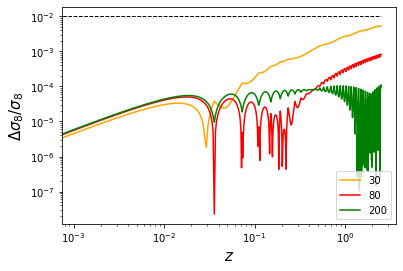

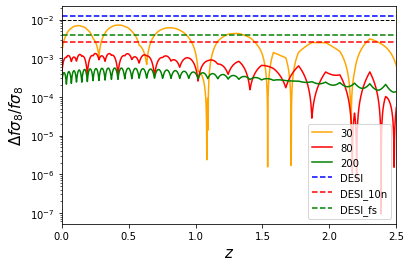

In [18]:
plt.figure()
plt.plot(zz[msk], np.fabs(d_10/dd_i-1)[msk], '-', color='orange', label='30')
plt.plot(zz[msk], np.fabs(d_100/dd_i-1)[msk], 'r-', label='80')
plt.plot(zz[msk], np.fabs(d_200/dd_i-1)[msk], 'g-', label='200')
#plt.plot(zz[msk], np.fabs(d_300/dd_i-1)[msk], 'b-', label='300')
#plt.plot(zz[msk], np.fabs(d_500/dd_i-1)[msk], 'y-', label='500')
#plt.plot(zz[msk], np.fabs(s8_200/dd_i-1)[msk], 'c-', label='200')
#plt.plot(zz[msk], np.fabs(s8_300/dd_i-1)[msk], 'k-', label='300')
plt.plot([0, 2.5], [0.01, 0.01], 'k--', lw=1)
plt.loglog()
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta \sigma_8/\sigma_8$', fontsize=15)
plt.legend(loc='lower right')
plt.figure()
plt.plot(zz[msk], np.fabs(dp_10/ddp_i-1)[msk], '-', color='orange', label='30')
plt.plot(zz[msk], np.fabs(dp_100/ddp_i-1)[msk], 'r-', label='80')
plt.plot(zz[msk], np.fabs(dp_200/ddp_i-1)[msk], 'g-', label='200')
#.plot(zz[msk], np.fabs(dp_300/ddp_i-1)[msk], 'b-', label='300')
#plt.plot(zz[msk], np.fabs(dp_500/ddp_i-1)[msk], 'y-', label='500')
#plt.plot(zz[msk], np.fabs(fs8_200/ddp_i-1)[msk], 'c-', label='200')
#plt.plot(zz[msk], np.fabs(fs8_300/ddp_i-1)[msk], 'k-', label='300')
plt.plot([0, 2.5], [0.01, 0.01], 'k--', lw=1)
plt.plot(z_int, DESI_fs8_threshold*np.ones_like(z_int), 'b--', label="DESI")
plt.plot(z_int, DESI10n_fs8_threshold*np.ones_like(z_int), 'r--', label="DESI_10n")
plt.plot(z_int, DESIfs_fs8_threshold*np.ones_like(z_int), 'g--', label="DESI_fs")
plt.xlim(0, 2.5)
plt.yscale("log")
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta f\sigma_8/f\sigma_8$', fontsize=15)
plt.legend(loc='lower right')
plt.show()

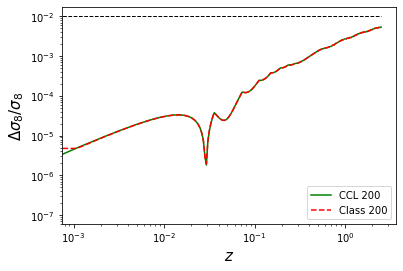

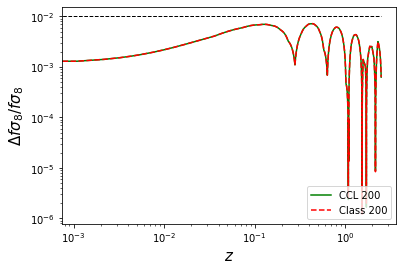

In [19]:
plt.figure()

plt.plot(zz[msk], np.fabs(d_10/dd_i-1)[msk], 'g-', label='CCL 200')
plt.plot(zz[msk], np.fabs(d_10/class_dd_i-1)[msk], 'r--', label='Class 200')
plt.plot([0, 2.5], [0.01, 0.01], 'k--', lw=1)
plt.loglog()
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta \sigma_8/\sigma_8$', fontsize=15)
plt.legend(loc='lower right')
plt.figure()
plt.plot(zz[msk], np.fabs(dp_10/ddp_i-1)[msk], 'g-', label='CCL 200')
plt.plot(zz[msk], np.fabs(dp_10/class_ddp_i-1)[msk], 'r--', label='Class 200')
plt.plot([0, 2.5], [0.01, 0.01], 'k--', lw=1)
plt.loglog()
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta f\sigma_8/f\sigma_8$', fontsize=15)
plt.legend(loc='lower right')
plt.show()